# Level 0 Regular Season Statistic Linear Models

In [1]:
import sys
import os
import json
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
sys.path.append("/Users/atticussoane/Desktop/atticus_tools/")
from recursive_selection import FeatureSelector

In [2]:
training = pd.read_csv("./engineered_data/regular_season_stat_training.csv.gz",
                      compression = "gzip")
validation = pd.read_csv("./engineered_data/regular_season_stat_validation.csv.gz",
                        compression = "gzip")

training = pd.concat([training, validation], axis = 0).reset_index(drop = True)

train_target = training["team1_win"]
training = training.drop(columns = ["team1_win"])

In [3]:
training.describe()

,team1_DRB_DIF,team1_ORB_DIF,team1_PPG,team1_PPP,team1_TRB_DIF,team1_ast_TO,team1_e_fg,team1_fg,team1_free_throw_pct,team1_opp_PPG,...,team2_opp_PPG,team2_opp_PPP,team2_opp_ast_TO,team2_opp_efg,team2_opp_fg,team2_opp_three_point_pct,team2_opp_trueshooting,team2_three_point_pct,team2_total_point_differential,team2_true_shooting
count,87504.000000,87504.000000,87504.000000,87504.000000,87504.000000,87504.000000,87504.000000,87504.000000,87502.000000,87504.000000,...,87504.000000,87504.000000,87504.000000,87504.000000,87504.000000,87504.000000,87504.000000,87504.000000,87504.000000,87504.000000
mean,1.436986,0.565928,67.423198,0.846848,2.002914,0.925575,0.476728,0.420305,0.664881,67.356637,...,67.369700,0.845783,0.919097,0.476582,0.420208,0.330505,0.515214,0.330305,5.556146,0.515702
std,52.464418,35.061235,14.630522,0.176355,69.939694,0.312456,0.098558,0.086630,0.134263,14.449930,...,14.449074,0.173053,0.307261,0.098062,0.086495,0.075410,0.103741,0.076749,131.961870,0.104510
min,-357.000000,-202.000000,0.000000,0.000000,-371.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-739.000000,0.000000
25%,-26.000000,-17.000000,64.157895,0.820401,-34.000000,0.768031,0.463470,0.408840,0.653199,64.428571,...,64.470588,0.825887,0.783186,0.463730,0.408657,0.315789,0.505316,0.312500,-64.000000,0.505155
50%,0.000000,0.000000,69.300000,0.876212,0.000000,0.923077,0.492043,0.433962,0.688312,69.148148,...,69.150000,0.874670,0.920863,0.491935,0.433533,0.340909,0.532654,0.340541,0.000000,0.533325
75%,28.000000,18.000000,74.291667,0.925771,37.000000,1.088608,0.519127,0.457286,0.720497,73.888889,...,73.882353,0.919159,1.071812,0.517723,0.456790,0.365217,0.557159,0.367769,71.000000,0.559283
max,345.000000,243.000000,144.000000,1.539956,393.000000,6.250000,0.824074,0.719298,1.000000,144.000000,...,129.000000,1.401631,29.000000,0.847222,0.777778,0.900000,0.830599,0.750000,772.000000,0.797503


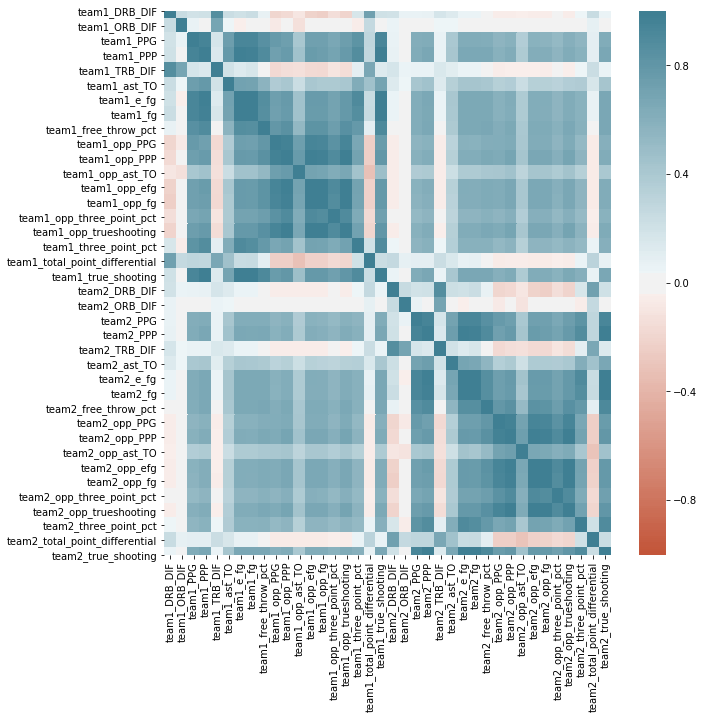

In [5]:
training_corr = training.corr()

fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(training_corr, cbar = True, vmin = -1, vmax= 1, center = 0,
            cmap=sns.diverging_palette(20, 220, n=200), ax = ax);

In [6]:
abs_corr = training_corr.abs()
correlated_pairs = abs_corr.where(np.triu(np.ones(abs_corr.shape), k =1).astype(np.bool)).stack().\
sort_values(ascending = False)

correlated_pairs[correlated_pairs > 0.9]

team1_opp_efg         team1_opp_fg                 0.993408
team2_opp_efg         team2_opp_fg                 0.993362
                      team2_opp_trueshooting       0.993260
team2_e_fg            team2_true_shooting          0.993137
team1_opp_efg         team1_opp_trueshooting       0.993106
team1_e_fg            team1_true_shooting          0.993093
                      team1_fg                     0.990983
team2_e_fg            team2_fg                     0.990852
team2_opp_fg          team2_opp_trueshooting       0.988539
team1_opp_fg          team1_opp_trueshooting       0.988481
team1_fg              team1_true_shooting          0.986860
team2_fg              team2_true_shooting          0.986658
team2_PPP             team2_true_shooting          0.986638
team1_PPP             team1_true_shooting          0.986475
team1_opp_PPP         team1_opp_trueshooting       0.985526
team2_opp_PPP         team2_opp_trueshooting       0.985503
team2_PPP             team2_e_fg        

In [3]:
def feature_frame_correlation(feature_frame, tol = None):
    feature_corr = feature_frame.corr().abs()
    correlated_pairs = feature_corr.where(np.triu(np.ones(feature_corr.shape), k =1).\
                                          astype(np.bool)).stack().sort_values(ascending = False)
    if tol:
        return(correlated_pairs[correlated_pairs > tol])
    else:
        return(correlated_pairs)
    
def get_correlation_with_winning(subset, df, target):
    df = pd.concat([df, target], axis = 1)
    partial = df[subset]
    partial_corr = partial.corr().abs()
    correlated_pairs = partial_corr.where(np.triu(np.ones(partial_corr.shape), k =1)\
                                      .astype(np.bool)).stack().sort_values(ascending = False)
    with_target = []
    for i in correlated_pairs.index:
        if "team1_win" in i:
            with_target.append(i)
    return(correlated_pairs[with_target])

def scale_features(data, binary_features, load_scaler = None, save_scaler = False):
    if binary_features:
        to_scale = data.drop(columns = binary_features)
    else:
        to_scale = data
    scale_columns = list(to_scale.columns)
    npX = np.array(to_scale)
    
    if not load_scaler:
        ss = StandardScaler()
        ss.fit(npX)
    else:
        ss = load_scaler
    npX = ss.transform(npX)
    scaled_X = pd.DataFrame(npX)
    scaled_X.columns = scale_columns
    if binary_features:
        scaled_X = pd.concat([scaled_X, data[binary_features]], axis = 1)
    if save_scaler:
        return(scaled_X, ss)
    else:
        return(scaled_X)

def recursive_VIF(training_data, tol, binary_features):
    over_tolerance = []
    if binary_features:
        training_data = training_data.drop(columns = binary_features)
    while True:
        training_data = training_data.assign(constant = 1)
        all_cols = list(training_data.columns)
        npX = np.array(training_data)
        vif = [variance_inflation_factor(npX, i) for i in np.arange(npX.shape[1])]
        vif_ = pd.Series(vif, index = all_cols)
        vif_ = vif_.drop('constant')
        max_vif = vif_.idxmax()
        if vif_.max() > tol:
            training_data = training_data.drop(columns = [max_vif, 'constant'])
            over_tolerance.append((max_vif, vif_[max_vif]))
        else:
            return(over_tolerance)
        
def display_coef(training_data, model):
    features = list(training_data.columns)
    coefs = list(abs(model.coef_[0]))
    coef_frame = pd.DataFrame({"feature" : features, "coefficient" : coefs}).\
    sort_values(by = ["coefficient"], ascending = False)
    zero_val = coef_frame[coef_frame.coefficient == 0.].feature
    print("There are {} coefficients with zero coefficient".format(len(zero_val)))
    print()
    print(zero_val.values)
    return(coef_frame)

In [8]:
scoring = ["team1_e_fg", "team1_PPP", "team1_fg", "team1_true_shooting", "team1_win",
          "team1_three_point_pct", "team1_PPG", "team1_ast_TO"]
defense = ["team1_opp_PPG", "team1_opp_PPP", "team1_opp_ast_TO", "team1_opp_efg", "team1_opp_fg",
          "team1_opp_three_point_pct", "team1_opp_trueshooting", "team1_win"]
rebounding = ["team1_ORB_DIF", "team1_DRB_DIF", "team1_TRB_DIF", "team1_total_point_differential", "team1_win"]

In [9]:
get_correlation_with_winning(scoring, training, train_target)

team1_win            team1_ast_TO             0.154065
                     team1_PPG                0.104516
team1_PPP            team1_win                0.102199
team1_fg             team1_win                0.091578
team1_e_fg           team1_win                0.089047
team1_true_shooting  team1_win                0.083945
team1_win            team1_three_point_pct    0.066350
dtype: float64

In [10]:
get_correlation_with_winning(defense, training, train_target)

team1_opp_ast_TO           team1_win    0.114349
team1_opp_PPG              team1_win    0.074697
team1_opp_PPP              team1_win    0.069390
team1_opp_fg               team1_win    0.064122
team1_opp_efg              team1_win    0.063251
team1_opp_trueshooting     team1_win    0.057692
team1_opp_three_point_pct  team1_win    0.041555
dtype: float64

In [11]:
get_correlation_with_winning(rebounding, training, train_target)

team1_total_point_differential  team1_win    0.239567
team1_DRB_DIF                   team1_win    0.166698
team1_TRB_DIF                   team1_win    0.165030
team1_ORB_DIF                   team1_win    0.079760
dtype: float64

In [5]:
selected_statistics = ["team1_ast_TO", "team1_PPG", "team1_PPP", "team2_ast_TO", "team2_PPG", "team2_PPP",
                      "team1_opp_ast_TO", "team1_opp_PPG", "team1_opp_PPP", "team2_opp_ast_TO",
                      "team2_opp_PPG", "team2_opp_PPP", "team1_total_point_differential", 
                      "team2_total_point_differential", "team1_TRB_DIF", "team2_TRB_DIF"]

selected_training = training[selected_statistics]

In [6]:
with open("./models/regular_season_stats_features.json", "w+") as f:
    json.dump(selected_statistics, f)

# BASELINE

In [5]:
game1_indices = selected_training[(selected_training.team1_PPG == 0.) | (selected_training.team2_PPG == 0.)].index

reduced_training = selected_training.drop(game1_indices, axis = 0).reset_index(drop = True)

In [6]:
train_targetR = train_target.drop(game1_indices, axis = 0).reset_index(drop = True)

In [20]:
lr_params = {
    "C" : 0.1,
    "penalty" : "l1",
    "solver" : "liblinear"
}

lr = LogisticRegression().set_params(**lr_params)
log_cv = cross_val_score(lr, reduced_training, train_targetR, scoring = "roc_auc", cv = 10, n_jobs = -1).mean()

print("The baseline cross-validated ROC-AUC score for LogisticRegression is {}".format(log_cv))

The baseline cross-validated ROC-AUC score for LogisticRegression is 0.7631351780719587


In [7]:
scaled_training, ss = scale_features(reduced_training, [], save_scaler = True)

In [9]:
with open("./models/regular_season_stat_standard_scaler.pk", "wb") as f:
    pickle.dump(ss, f)

In [25]:
lr = LogisticRegression().set_params(**lr_params)
log_cv = cross_val_score(lr, scaled_training, train_targetR, scoring = "roc_auc", cv = 10, n_jobs = -1).mean()

print("The baseline cross-validated ROC-AUC score with scaled data for LogisticRegression is {}".format(log_cv))

The baseline cross-validated ROC-AUC score with scaled data for LogisticRegression is 0.7634892352432642


In [26]:
feature_frame_correlation(scaled_training, 0.75)

team1_PPG      team1_PPP        0.808382
team2_PPG      team2_PPP        0.807856
team1_opp_PPG  team1_opp_PPP    0.805039
team2_opp_PPG  team2_opp_PPP    0.803053
team2_ast_TO   team2_PPP        0.759262
team1_ast_TO   team1_PPP        0.757507
dtype: float64

In [27]:
recursive_VIF(scaled_training, 5.0, [])

[('team1_PPG', 15.126977291044918), ('team2_PPG', 14.603068645326744)]

In [28]:
drop_cols = ["team2_PPG", "team1_PPG", "team1_opp_PPG", "team2_opp_PPG"]

lr = LogisticRegression().set_params(**lr_params)
log_cv = cross_val_score(lr, scaled_training.drop(columns = drop_cols), 
                         train_targetR, scoring = "roc_auc", cv = 10, n_jobs = -1).mean()

print("The baseline cross-validated ROC-AUC score with scaled data for LogisticRegression is {}".format(log_cv))

The baseline cross-validated ROC-AUC score with scaled data for LogisticRegression is 0.7595053051542868


## L1 Regularization

In [29]:
l1_param_search = {
    "solver" : ["liblinear", "saga"],
    "fit_intercept" : [True, False],
    "C" : [0.01, 0.1, 1.0, 10.0]
}

model = LogisticRegression(penalty = "l1")
grid_search = GridSearchCV(model, param_grid = l1_param_search, scoring = "roc_auc", n_jobs = -1,
                          cv = 5)

grid_search.fit(scaled_training, train_targetR)
print('Best score: {}'.format(grid_search.best_score_))
print()
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.7635056722479091

Best parameters: {'C': 10.0, 'fit_intercept': False, 'solver': 'liblinear'}


## L2 Regularization

In [32]:
l2_param_search = {
    "solver" : ["newton-cg", "lbfgs", "sag", "saga", "liblinear"],
    "fit_intercept" : [True, False],
    "C" : [0.01, 0.1, 1.0, 10.0]
}

model = LogisticRegression(penalty = "l2")
grid_search = GridSearchCV(model, param_grid = l2_param_search, scoring = "roc_auc", n_jobs = -1,
                          cv = 5)

grid_search.fit(scaled_training, train_targetR)
print('Best score: {}'.format(grid_search.best_score_))
print()
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.7635062258087788

Best parameters: {'C': 10.0, 'fit_intercept': False, 'solver': 'liblinear'}


## ElasticNet Regularization

In [35]:
elasticnet_param_search = {
    "C" : [0.01, 0.1, 1.0, 10., 100.],
    "fit_intercept" : [True, False],
    "l1_ratio" : [0.1, 0.25, 0.5, 0.75]
}

model = LogisticRegression(penalty = "elasticnet", solver = "saga")
grid_search = GridSearchCV(model, param_grid = elasticnet_param_search, scoring = "roc_auc", n_jobs = -1,
                          cv = 5)

grid_search.fit(scaled_training, train_targetR)
print('Best score: {}'.format(grid_search.best_score_))
print()
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.7635011271956496

Best parameters: {'C': 10.0, 'fit_intercept': False, 'l1_ratio': 0.1}


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


With a high value for __C__ and virtually the same evaluation regardless of what regularization penalty is chosen, these results show that adding a regularization penalty is not helping the model. This is concerning because it likely means the model is overfitting to the training data, but for now we will go with it. 

In [38]:
best_params = {
    "penalty" : "l1",
    "solver" : "liblinear",
    "C" : 10.0,
    "fit_intercept" : False
}

lr = LogisticRegression().set_params(**lr_params)
log_cv = cross_val_score(lr, scaled_training, train_targetR, scoring = "roc_auc", cv = 10, n_jobs = -1).mean()

print("The tuned cross-validated ROC-AUC score for LogisticRegression is {}".format(log_cv))

The tuned cross-validated ROC-AUC score for LogisticRegression is 0.7634898198670469


We are not seeing any improvement through feature parameter tuning. Moving on to a different linear model.

## SGD Classifier

## Hinge Loss- SVM

In [12]:
SVM_param_search = {
    "loss" : ["hinge", "squared_hinge"],
    "penalty" : ["l1", "l2", "elasticnet"],
    "alpha" : [0.0001, 0.001, 0.1],
    "learning_rate" : ["optimal", "adaptive"]    
}

model = SGDClassifier(fit_intercept = False, eta0 = 0.1)
grid_search = GridSearchCV(model, param_grid = SVM_param_search, scoring = "roc_auc", n_jobs = -1,
                          cv = 5)

grid_search.fit(scaled_training, train_targetR)
print('Best score: {}'.format(grid_search.best_score_))
print()
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.763499363073824

Best parameters: {'alpha': 0.0001, 'learning_rate': 'adaptive', 'loss': 'squared_hinge', 'penalty': 'elasticnet'}


## Modified Huber Loss

In [13]:
MH_param_search = {
    "penalty" : ["l1", "l2", "elasticnet"],
    "alpha" : [0.0001, 0.001, 0.01, 0.1],
    "learning_rate" : ["optimal", "adaptive"]
}

model = SGDClassifier(fit_intercept = False, eta0 = 0.1, loss = "modified_huber")
grid_search = GridSearchCV(model, param_grid = MH_param_search, scoring = "roc_auc", n_jobs = -1,
                          cv = 5)

grid_search.fit(scaled_training, train_targetR)
print('Best score: {}'.format(grid_search.best_score_))
print()
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.7634964615445852

Best parameters: {'alpha': 0.0001, 'learning_rate': 'adaptive', 'penalty': 'l1'}


## Check Learning Rate, as adaptive learning rate was used

In [16]:
LR_search = {
    "eta0" : [0.01, 0.1, 1.0, 10.]
}

SGD_params = {
    "penalty" : "elasticnet",
    "learning_rate" : "adaptive",
    "alpha" : 0.0001,
    "loss" : "squared_hinge",
    "fit_intercept" : False,
    "eta0" : 0.1
}

model = SGDClassifier().set_params(**SGD_params)
grid_search = GridSearchCV(model, param_grid = LR_search, scoring = "roc_auc", n_jobs = -1,
                          cv = 5)

grid_search.fit(scaled_training, train_targetR)
print('Best score: {}'.format(grid_search.best_score_))
print()
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.763502803318083

Best parameters: {'eta0': 0.1}


# TRAIN TWO FINAL LINEAR MODELS - SGDClassifer (SVM) and LogisticRegression

In [18]:
##SGDClassifier 
SGD_params = {
    "loss" : "squared_hinge",
    "penalty" : "elasticnet",
    "alpha" : 0.0001,
    "learning_rate" : "adaptive",
    "eta0" : 0.1,
    "fit_intercept" : False
}

log_params = {
    "solver" : "liblinear",
    "penalty" : "l1",
    "C" : 10.,
    "fit_intercept" : False,
}

sgd_final = SGDClassifier().set_params(**SGD_params)
log_final = LogisticRegression().set_params(**log_params)

sgd_final.fit(scaled_training, train_targetR)
log_final.fit(scaled_training, train_targetR)

LogisticRegression(C=10.0, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [19]:
sgd_coef = display_coef(scaled_training, sgd_final)
log_coef = display_coef(scaled_training, log_final)

There are 1 coefficients with zero coefficient

['team1_opp_ast_TO']
There are 0 coefficients with zero coefficient

[]


In [20]:
sgd_coef

,feature,coefficient
7,team1_opp_PPG,0.237488
1,team1_PPG,0.236688
10,team2_opp_PPG,0.227658
4,team2_PPG,0.226849
12,team1_total_point_differential,0.178461
13,team2_total_point_differential,0.177317
11,team2_opp_PPP,0.082791
8,team1_opp_PPP,0.080052
5,team2_PPP,0.043085
2,team1_PPP,0.042937


In [21]:
log_coef

,feature,coefficient
7,team1_opp_PPG,0.608045
1,team1_PPG,0.605368
10,team2_opp_PPG,0.578490
4,team2_PPG,0.576632
12,team1_total_point_differential,0.420333
13,team2_total_point_differential,0.417184
11,team2_opp_PPP,0.208346
8,team1_opp_PPP,0.206592
2,team1_PPP,0.112789
5,team2_PPP,0.109891


In [22]:
with open("./models/reg_season_stats_log.pk", "wb") as f:
    pickle.dump(log_final, f)

with open("./models/reg_season_stats_SVM.pk", "wb") as f:
    pickle.dump(sgd_final, f)